### Pip Install Commands

In [1]:
%pip install numpy pandas matplotlib scikit-learn lightgbm xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import xgboost as xgb
from numpy import fft


### Load the data

In [3]:
## This file contains historical data from around March to May 2024.

df_omie_labelled = pd.read_csv('../data/df_omie_labelled.csv')

# ---------------------

## Contains information on the technology type (Wind or Solar) for each plant, 
## which may be useful for grouping. 

df_filtered_cat = pd.read_csv('../data/filtered_categories.csv')

# ---------------------
## Additional information about generation units that you can use if needed.

df_unit_list = pd.read_csv('../data/unit_list.csv')

### Data Merging & Filtering

In [4]:
merged_df = df_omie_labelled.merge(df_unit_list, on='Codigo', how='left')
merged_df = merged_df.merge(df_filtered_cat, on='Codigo', how='left')
codes = df_filtered_cat['Codigo'].unique()
merged_df = merged_df[merged_df['Codigo'].isin(codes)]

### Feature Engineering Functions


In [5]:
def time_features(df: pd.DataFrame):
    df['fechaHora'] = pd.to_datetime(df['fechaHora'])
    df['date'] = df['fechaHora'].dt.date
    df['hour'] = df['fechaHora'].dt.hour
    df['day_of_week'] = df['fechaHora'].dt.dayofweek  # Monday=0, Sunday=6
    df['month'] = df['fechaHora'].dt.month
    df['day_of_month'] = df['fechaHora'].dt.day
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df.sort_values(['fechaHora', 'Codigo'], inplace=True)
    # Create a time index (in hours) since the start
    df['t'] = (df['fechaHora'] - df['fechaHora'].min()).dt.total_seconds() / 3600

    # Create sin/cos features for capturing cyclic behavior over a 24-hour period.
    def sin_cos_features(df: pd.DataFrame, period, K, time_col='t'):
        df = df.sort_values(['Codigo', 'fechaHora'])
        for k in range(1, K + 1):
            df[f'sin_{period}_{k}'] = np.sin(2 * np.pi * k * df[time_col] / period)
            df[f'cos_{period}_{k}'] = np.cos(2 * np.pi * k * df[time_col] / period)
        return df

    df = sin_cos_features(df, period=24, K=3)
    return df    

def cyclical_features(df: pd.DataFrame):
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    return df
        
def interaction_features(df: pd.DataFrame):
    df['energia_hour_sin'] = df['lag_Energia'] * df['hour_sin']
    return df
    
def lags_features(df: pd.DataFrame):
    df.sort_values(['fechaHora'], inplace=True)
    # Primary lag features (using 28-day window)
    df['lag_PrecEuro'] = df.groupby('Codigo')['PrecEuro'].shift(24*28)
    df['lag_Energia'] = df.groupby('Codigo')['Energia'].shift(24*28)
    df['lag_Energia'] = np.log(df['lag_Energia'] + 1)
    df['lag1_Energia'] = df.groupby('Codigo')['lag_Energia'].shift(1)
    df['lag24_Energia'] = df.groupby('Codigo')['lag_Energia'].shift(24)
    
    # Additional lag features at different windows:
    df['lag_7d_Energia'] = df.groupby('Codigo')['Energia'].shift(24*7)
    df['lag_14d_Energia'] = df.groupby('Codigo')['Energia'].shift(24*14)
    df['lag_7d_PrecEuro'] = df.groupby('Codigo')['PrecEuro'].shift(24*7)
    df['lag_14d_PrecEuro'] = df.groupby('Codigo')['PrecEuro'].shift(24*14)
    
    # Rolling statistics to smooth out noise:
    # 7-day rolling statistics for Energia
    df['rolling_mean_7d_Energia'] = df.groupby('Codigo')['Energia']\
        .transform(lambda x: x.rolling(window=24*7, min_periods=1).mean())
    df['rolling_std_7d_Energia'] = df.groupby('Codigo')['Energia']\
        .transform(lambda x: x.rolling(window=24*7, min_periods=1).std())
    df['rolling_q75_7d_Energia'] = df.groupby('Codigo')['Energia']\
        .transform(lambda x: x.rolling(window=24*7, min_periods=1).quantile(0.75))
    
    # 28-day rolling statistics for Energia
    df['rolling_mean_28d_Energia'] = df.groupby('Codigo')['Energia']\
        .transform(lambda x: x.rolling(window=24*28, min_periods=1).mean())
    df['rolling_std_28d_Energia'] = df.groupby('Codigo')['Energia']\
        .transform(lambda x: x.rolling(window=24*28, min_periods=1).std())
    
    return df

In [6]:
def feature_engineering(data: pd.DataFrame):
    # Create a stationary version of Energia via differencing
    data['Energia_stationary'] = data['Energia'].diff()
    data = lags_features(data)
    data = time_features(data)
    data = cyclical_features(data)
    data = interaction_features(data)
    data = data.sort_values(['fechaHora', 'Codigo'])
    return data

### Feature Transformation Functions

In [7]:
def agg_features(df: pd.DataFrame):
    df['cum_energy'] = df.groupby(['Codigo', 'date'])['lag_Energia'].cumsum()
    return df

def rolling_mean_features(df: pd.DataFrame):
    features = ['lag_Energia', 'lag_PrecEuro']
    groups = ['Codigo', 'Categoria']
    times = [12, 24, 48, 168]
    for group in groups:
        for feature in features:
            for time in times:
                df[f'roll{time}_mean_{feature}'] = df.groupby(group)[feature] \
                    .transform(lambda x: x.rolling(window=time, min_periods=1).mean())
    return df

def ewm_features(df: pd.DataFrame):
    features = ['lag_Energia', 'lag_PrecEuro']
    groups = ['Codigo', 'Categoria']
    spans = [12, 24, 48, 168]
    for group in groups:
        for feature in features:
            for span in spans:
                df[f'ewm{span}_mean_{feature}'] = df.groupby(group)[feature] \
                    .transform(lambda x: x.ewm(span=span, min_periods=1).mean())
    return df

def diff_features(df: pd.DataFrame):
    features = ['lag_Energia', 'lag_PrecEuro']
    for feature in features:
        df[f'diff_{feature}'] = df.groupby('Codigo')[feature].diff()
        df[f'diff_{feature}'] = df.groupby(['Codigo'])[f'diff_{feature}'].transform(lambda x: x.fillna(x.mean()))
    return df

def volatility_features(df: pd.DataFrame):
    features = ['lag_Energia', 'lag_PrecEuro']
    groups = ['Codigo', 'Categoria']
    windows = [12, 24, 48, 168]
    for group in groups:
        for feature in features:
            for window in windows:
                df[f'volatility_{window}_{feature}'] = df.groupby(group)[feature] \
                    .transform(lambda x: x.rolling(window=window, min_periods=1).std())
                df[f'volatility_{window}_{feature}'] = df.groupby(['Codigo'])[f'volatility_{window}_{feature}'].transform(lambda x: x.fillna(x.mean()))

    return df

def fourrier_features(df: pd.DataFrame):    
    def apply_fft(group):
            X = fft.fft(group['lag_Energia'])
            N = len(X)
            group['lag_Energia_fft'] = np.abs(X) / N  # Normalize by length
            return group

    df = df.groupby('Codigo', group_keys=False).apply(apply_fft)
    return df

def frequency_power_features(df: pd.DataFrame):
    df['power_spectrum'] = df.groupby('Codigo')['lag_Energia'].transform(lambda x: np.abs(fft.fft(x))**2 / len(x))
    return df

In [8]:
def feature_transformation(x_train):
    x_train = agg_features(x_train)
    x_train = rolling_mean_features(x_train)
    x_train = ewm_features(x_train)
    x_train = diff_features(x_train)
    x_train = volatility_features(x_train)
    x_train = fourrier_features(x_train)
    x_train = frequency_power_features(x_train)
    x_train['zero_indicator'] = (x_train['lag_Energia'] == 0).astype(int)
    return x_train

### Prepare Training & Forecast Data

In [9]:
def prepare_training_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Applies the complete feature engineering pipeline to the training data.
    """
    df_fe = feature_engineering(df.copy())
    df_fe = feature_transformation(df_fe)
    return df_fe

def prepare_forecast_data(df_history: pd.DataFrame, forecast_start: pd.Timestamp, forecast_end: pd.Timestamp) -> pd.DataFrame:
    forecast_index = pd.date_range(start=forecast_start, end=forecast_end, freq='H')
    codigos = df_history['Codigo'].unique()
    forecast_df = pd.DataFrame([{'fechaHora': ts, 'Codigo': codigo} for codigo in codigos for ts in forecast_index])
    forecast_df = forecast_df.merge(df_unit_list, on='Codigo', how='left')
    forecast_df = forecast_df.merge(df_filtered_cat, on='Codigo', how='left')
    combined_df = pd.concat([df_history.copy(), forecast_df], sort=False).reset_index(drop=True)
    combined_df = feature_engineering(combined_df)
    forecast_features = combined_df[combined_df['fechaHora'] >= forecast_start].copy()
    return forecast_features


### Forecast Boudaries

In [10]:
forecast_start = pd.Timestamp('2024-06-01 23:00:00')
forecast_end   = pd.Timestamp('2024-06-29 23:00:00')

# Convert 'fechaHora' to datetime
merged_df['fechaHora'] = pd.to_datetime(merged_df['fechaHora'])

# Use only data before forecast_start for training
train_df = merged_df[merged_df['fechaHora'] < forecast_start].copy()
train_df = prepare_training_data(train_df)

/var/folders/p1/vj5nk3dj08nbdgjg1lst8k_w0000gn/T/ipykernel_82451/3883808718.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Codigo', group_keys=False).apply(apply_fft)


### Winsorizing

In [11]:
def winsorize_column(df, column, multiplier=0.0001):
    """
    Clips the values of ⁠ column ⁠ in df to be within [Q1 - multiplier*IQR, Q3 + multiplier*IQR].
    """
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - multiplier * iqr
    upper_bound = q3 + multiplier * iqr
    df[column] = df[column].clip(lower_bound, upper_bound)
    return df

train_df = winsorize_column(train_df, 'Energia_stationary')

### Define Feature Lists & Target

In [12]:
categorical_features = ['Codigo'] + [col for col in ['Categoria', 'Tipo_Unidad', 'Zona/Frontera', 'Tecnología', 'Agente'] if col in train_df.columns]

EXCLUDED_COLS = ['fechaHora', 'date', 'Energia', 'PrecEuro', 'Energia_stationary']
# Get numerical features from the feature-engineered training data
numerical_features = [col for col in train_df.select_dtypes(include=[np.number]).columns if col not in EXCLUDED_COLS]
metadata_features = [col for col in ['agent_frequency', 'avg_propiedad_by_agent'] if col in train_df.columns]

# Final feature list and target definition
feature_cols = categorical_features + numerical_features + metadata_features
target_col = 'Energia_stationary'

# Convert categorical features to type 'category'
for col in categorical_features:
    if col in train_df.columns:
        train_df[col] = train_df[col].astype('category')

# Drop rows with missing target values
train_df = train_df.dropna(subset=[target_col])

# Create Zero Indicator Feature
train_df['zero_indicator'] = (train_df['lag_Energia'] == 0).astype(int)
if 'zero_indicator' not in feature_cols:
    feature_cols.append('zero_indicator')

# Drop rows with NaN values in 'Energia_stationary'
train_df = train_df.dropna(subset=['Energia_stationary'])

# Split into features and target
X = train_df[feature_cols]
y = train_df[target_col]

In [13]:
print(f"Total training samples: {X.shape[0]}")

Total training samples: 703247


### Rolling Window Cross-Validation

In [14]:
def custom_rolling_window_cv(data: pd.DataFrame, initial_train_window: int, forecast_horizon: int, step: int):
    """
    Custom rolling window cross-validation.
    """
    n = len(data)
    train_end = initial_train_window  
    while (train_end + forecast_horizon) <= n:
        train_idx = list(range(0, train_end))
        test_idx = list(range(train_end, train_end + forecast_horizon))
        yield train_idx, test_idx
        train_end += step
        
nunique_codes = X['Codigo'].nunique()

INITIAL_TRAIN_WINDOW = 24*28*nunique_codes
FORECAST_HORIZON = 24*28*nunique_codes
STEP = 24*7*nunique_codes

### Metrics Functions

In [15]:
epsilon = 0.001
def adjusted_mape(y_true, y_pred, epsilon=0.001):
    """Adjusted MAPE: adds epsilon to avoid division by zero."""
    return np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + epsilon))

def mape_eval(preds, dtrain):
    """Custom evaluation metric: MAPE."""
    labels = dtrain.get_label()
    epsilon = 1e-6
    mape = np.mean(np.abs(preds - labels) / (np.abs(labels) + epsilon))
    return 'mape', mape

### Hyperparameters

In [16]:
params_lgb = {
    'metric': 'mae',
    'learning_rate': 0.04139126441377782,
    'num_leaves': 59,
    'max_depth': 7,
    'min_data_in_leaf': 26,
    'feature_fraction': 0.9999701887398744,
    'bagging_fraction': 0.6553188710984839,
    'bagging_freq': 6,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'verbose': -1,
    'seed': 42
}

params_xgb = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.08996762182053374,
    'max_depth': 12,
    'min_child_weight': 15,
    'subsample': 0.9311934043147285,
    'colsample_bytree': 0.9207112604165268,
    'gamma': 0.05492341594511156,
    'reg_alpha': 1.8601319939498554e-06,
    'reg_lambda': 1.0612755474577377e-08,
    'seed': 42,
    'verbosity': 1
}

### Asymmetric Loss Function

In [17]:
def asymmetric_mape_obj(preds, dtrain):
    """
    Custom objective function that uses a squared percentage error,
    weighted asymmetrically based on the sign of the error.
    Loss: L = c * ((pred - label) / (label + epsilon))^2
    where c = a if (pred - label) >= 0, else c = b.
    """
    labels = dtrain.get_label()
    epsilon = 1e-6
    # Set weights for asymmetry:
    a = 1.5  # weight when overpredicting
    b = 1.0  # weight when underpredicting
    diff = preds - labels
    c = np.where(diff >= 0, a, b)
    denom = labels + epsilon
    grad = 2 * c * diff / (denom**2)
    hess = 2 * c / (denom**2)
    return grad, hess

def asymmetric_mape_obj_lgb(preds, train_data):
    """
    Custom objective function for LightGBM that uses a squared percentage error,
    weighted asymmetrically based on the sign of the error.
    Loss: L = c * ((pred - label) / (label + epsilon))^2
    where c = a if (pred - label) >= 0, else c = b.
    """
    labels = train_data.get_label()
    epsilon = 1e-6
    # Set weights for asymmetry:
    a = 1.5  # weight when overpredicting
    b = 1.0  # weight when underpredicting
    diff = preds - labels
    c = np.where(diff >= 0, a, b)
    
    min_label = 0.1  # adjust based on your data distribution
    safe_labels = np.maximum(labels, min_label)
    denom = safe_labels + epsilon

    # denom = labels + epsilon
    
    
    grad = 2 * c * diff / (denom**2)
    hess = 2 * c / (denom**2)
    return grad, hess

### AVG Energia per Categoria

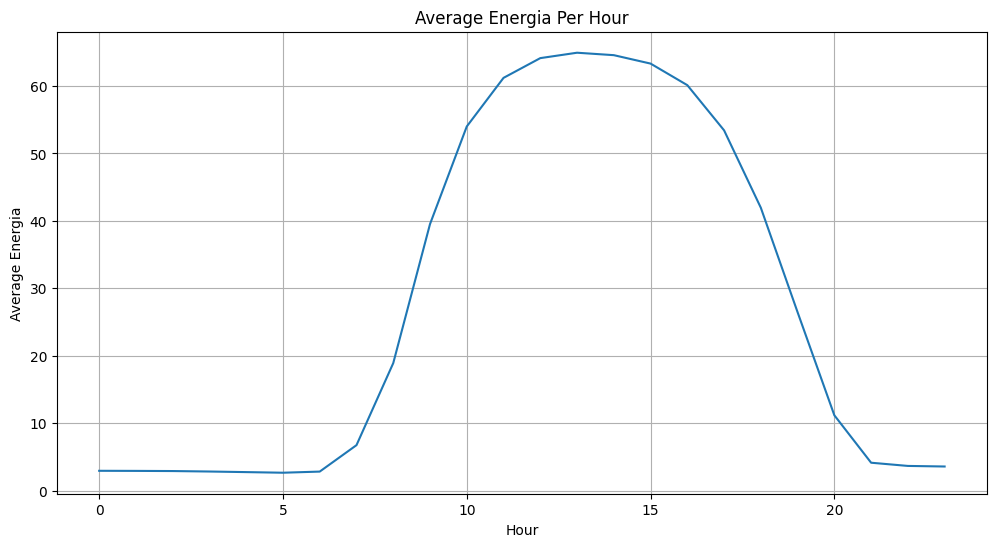

In [18]:

eolica_merged = merged_df[merged_df['Categoria'] == 'Solar']

avg_energia_per_hour = eolica_merged.groupby(eolica_merged['fechaHora'].dt.hour)['Energia'].mean()

# Plot the result
plt.figure(figsize=(12, 6))
avg_energia_per_hour.plot()
plt.title('Average Energia Per Hour')
plt.xlabel('Hour')
plt.ylabel('Average Energia')
plt.grid(True)
plt.show()

### Cross-Validation 

In [19]:
mae_scores = []
mape_scores = []

for fold, (train_index, val_index) in enumerate(custom_rolling_window_cv(X, INITIAL_TRAIN_WINDOW, FORECAST_HORIZON, STEP)):
    X_tr = X.iloc[train_index]
    y_tr = y.iloc[train_index]
    X_val_fold = X.iloc[val_index]
    y_val_fold = y.iloc[val_index]
            
    # ----- Train LightGBM -----
    lgb_train = lgb.Dataset(X_tr, label=y_tr, categorical_feature=categorical_features + ['zero_indicator'])
    lgb_val = lgb.Dataset(X_val_fold, label=y_val_fold, categorical_feature=categorical_features + ['zero_indicator'])
    
    params_lgb['objective'] = asymmetric_mape_obj_lgb
    
    model_lgb = lgb.train(
        params_lgb,
        lgb_train,
        num_boost_round=1000,
        valid_sets=[lgb_train, lgb_val],
        callbacks=[lgb.early_stopping(stopping_rounds=50)]
    )
    
    y_pred_lgb = model_lgb.predict(X_val_fold, num_iteration=model_lgb.best_iteration)
    
    # ----- Train XGBoost with custom asymmetric loss -----
    dtrain = xgb.DMatrix(X_tr, label=y_tr, enable_categorical=True)
    dval = xgb.DMatrix(X_val_fold, label=y_val_fold, enable_categorical=True)
    watchlist = [(dtrain, 'train'), (dval, 'eval')]
    
    model_xgb = xgb.train(
        params_xgb,
        dtrain,
        num_boost_round=1000,
        evals=watchlist,
        early_stopping_rounds=50,
        verbose_eval=False,
        obj=asymmetric_mape_obj,
        custom_metric=mape_eval
    )
    
    dX_val = xgb.DMatrix(X_val_fold, enable_categorical=True)
    if hasattr(model_xgb, 'best_iteration'):
        y_pred_xgb = model_xgb.predict(dX_val, iteration_range=(0, model_xgb.best_iteration + 1))
    else:
        y_pred_xgb = model_xgb.predict(dX_val)
    
    # ----- Ensemble Predictions (Simple Average) -----
    y_pred_ensemble = (y_pred_lgb + y_pred_xgb) / 2.0
    
    # Clip predictions using a floor and ceiling to reduce extreme errors:
    floor_value = 0  # Energy supply cannot be negative.
    ceiling_solar = 453.3
    ceiling_wind = 453.3 

    # Clip predictions for Solar category
    solar_mask = (X_val_fold['Categoria'] == 'Solar')
    y_pred_ensemble_clipped = y_pred_ensemble.copy()
    y_pred_ensemble_clipped[solar_mask] = np.clip(y_pred_ensemble[solar_mask], floor_value, ceiling_solar)

    # Clip predictions for Wind category
    wind_mask = (X_val_fold['Categoria'] == 'Eolica')
    y_pred_ensemble_clipped[wind_mask] = np.clip(y_pred_ensemble[wind_mask], floor_value, ceiling_wind)
    
    # Adjust predictions
    solar_mask = (X_val_fold['Categoria'] == 'Solar') & ((X_val_fold['hour'] >= 1) | (X_val_fold['hour'] < 6))
    y_pred_ensemble_clipped[solar_mask] = 0
    
    wind_mask = (X_val_fold['Categoria'] == 'Eolica') & ((X_val_fold['hour'] >=00) | (X_val_fold['hour'] < 6))
    y_pred_ensemble_clipped[wind_mask] = 0
    
    fold_mae = mean_absolute_error(y_val_fold, y_pred_ensemble_clipped)
    fold_mape = adjusted_mape(y_val_fold, y_pred_ensemble_clipped)
    print("\n--------------------------------------------")
    print(f"Fold {fold}: Ensemble MAE = {fold_mae:.4f}, Ensemble MAPE = {fold_mape:.4f}\n")
    
    mae_scores.append(fold_mae)
    mape_scores.append(fold_mape)
    fold += 1

avg_mae = np.mean(mae_scores)
avg_mape = np.mean(mape_scores)

print("--------------------------------------------")
print(f"\nAverage Ensemble MAE  across folds: {avg_mae:.4f}")
print("--------------------------------------------")
print(f"\nAverage Ensemble MAPE across folds: {avg_mape:.4f}")

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	training's l1: 4.67121	valid_1's l1: 4.96345

--------------------------------------------
Fold 0: Ensemble MAE = 5.0392, Ensemble MAPE = 0.8165

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	training's l1: 4.73567	valid_1's l1: 4.96958

--------------------------------------------
Fold 1: Ensemble MAE = 5.0214, Ensemble MAPE = 0.8239

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[6]	training's l1: 4.7996	valid_1's l1: 4.98217

--------------------------------------------
Fold 2: Ensemble MAE = 5.0131, Ensemble MAPE = 0.8287

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	training's l1: 4.79795	valid_1's l1: 4.97392

--------------------------------------------
Fold 3: Ensemble MAE = 5.0196, Ensemble MAPE = 0.8339

Training until va

### Forecast

In [20]:
FORECAST_START = pd.Timestamp('2024-06-01 23:00:00')
FORECAST_END = pd.Timestamp('2024-06-29 23:00:00')

forecast_df = prepare_forecast_data(train_df, FORECAST_START, FORECAST_END)

/var/folders/p1/vj5nk3dj08nbdgjg1lst8k_w0000gn/T/ipykernel_82451/1655613367.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=forecast_start, end=forecast_end, freq='H')


### Train our models on the train set. 

In [21]:
lgb_train_full = lgb.Dataset(X, label=y, categorical_feature=categorical_features + ['zero_indicator'])

final_model_lgb = lgb.train(
    params_lgb,
    lgb_train_full,
    num_boost_round=1000
)


In [22]:
dtrain_full = xgb.DMatrix(X, label=y, enable_categorical=True)

final_model_xgb = xgb.train(
    params_xgb,
    dtrain_full,
    num_boost_round=1000,
    verbose_eval=False,
    obj=asymmetric_mape_obj,
    custom_metric=mape_eval
)

In [23]:
for col in categorical_features:
    if col in forecast_df.columns and col in X.columns:
        forecast_df[col] = forecast_df[col].astype('category')
        forecast_df[col] = forecast_df[col].cat.set_categories(X[col].cat.categories)

X_forecast = forecast_df[feature_cols].copy()

In [24]:
y_pred_lgb_forecast = final_model_lgb.predict(X_forecast, num_iteration=final_model_lgb.best_iteration)
dforecast = xgb.DMatrix(X_forecast, enable_categorical=True)
if hasattr(final_model_xgb, 'best_iteration'):
    
    y_pred_xgb_forecast = final_model_xgb.predict(dforecast, iteration_range=(0, final_model_xgb.best_iteration + 1))
else:
    y_pred_xgb_forecast = final_model_xgb.predict(dforecast)

y_pred_ensemble_forecast = (y_pred_lgb_forecast + y_pred_xgb_forecast) / 2.0


In [25]:
# Invert Differenced Predictions

baseline = train_df.groupby('Codigo')['Energia'].last()

X_forecast = X_forecast.copy() 
forecast_df = forecast_df.copy()
forecast_df["Energia_stationary_pred"] = y_pred_ensemble_forecast

/var/folders/p1/vj5nk3dj08nbdgjg1lst8k_w0000gn/T/ipykernel_82451/1323449911.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  baseline = train_df.groupby('Codigo')['Energia'].last()


In [26]:
def invert_differenced_predictions(df, baseline_series):
    df = df.sort_values(['Codigo', 'fechaHora']).copy()
    inverted_frames = []
    for code, group in df.groupby('Codigo'):
        base_val = baseline_series.loc[code]

        group = group.sort_values('fechaHora').copy()
        group["Energia"] = group["Energia_stationary_pred"].cumsum() + base_val
        inverted_frames.append(group)
    return pd.concat(inverted_frames, ignore_index=True)


In [27]:
forecast_inverted = invert_differenced_predictions(forecast_df, baseline)

/var/folders/p1/vj5nk3dj08nbdgjg1lst8k_w0000gn/T/ipykernel_82451/4085508915.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for code, group in df.groupby('Codigo'):


In [ ]:
# ---- Post-Processing: Clip and Adjust Predictions ----

floor_value = 0
ceiling_solar = 453.3
ceiling_wind = 453.3

solar_mask = (forecast_inverted['Categoria'] == 'Solar')
wind_mask = (forecast_inverted['Categoria'] == 'Eolica')
forecast_inverted.loc[solar_mask, 'Energia'] = np.clip(forecast_inverted.loc[solar_mask, 'Energia'], floor_value, ceiling_solar)
forecast_inverted.loc[wind_mask, 'Energia'] = np.clip(forecast_inverted.loc[wind_mask, 'Energia'], floor_value, ceiling_wind)

solar_time_mask = (forecast_inverted['Categoria'] == 'Solar') & ((forecast_inverted['hour'] >= 1) & (forecast_inverted['hour'] < 6))
forecast_inverted.loc[solar_time_mask, 'Energia'] = 0
wind_time_mask = (forecast_inverted['Categoria'] == 'Eolica') & ((forecast_inverted['hour'] >= 0) & (forecast_inverted['hour'] < 6))
forecast_inverted.loc[wind_time_mask, 'Energia'] = 0


In [29]:
final_forecast_output = forecast_inverted[['Codigo', 'fechaHora', 'Energia']].copy()
final_forecast_output = final_forecast_output.sort_values(['Codigo', 'fechaHora'])

print("Final Forecast Output Sample:")
print(final_forecast_output.head())

# Save the final forecast output to a CSV file
final_forecast_output.to_csv("Challenge1_404TeamNotFound.csv", index=False)


Final Forecast Output Sample:
    Codigo           fechaHora  Energia
0  ADXVD03 2024-06-01 23:00:00      0.0
1  ADXVD03 2024-06-02 00:00:00      0.0
2  ADXVD03 2024-06-02 01:00:00      0.0
3  ADXVD03 2024-06-02 02:00:00      0.0
4  ADXVD03 2024-06-02 03:00:00      0.0
